In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

# 1️⃣ Load historical data
df = pd.read_csv('../data/processed/cleaned_data.csv', index_col='Date', parse_dates=True)
df = df[['TSLA', 'BND', 'SPY']].dropna()

# 2️⃣ Expected Returns
# Use LSTM forecast for TSLA (from Task 3)
forecasted_prices = pd.read_csv('../data/processed/tsla_lstm_forecast.csv', index_col='Date', parse_dates=True)
tsla_forecast_returns = forecasted_prices['Forecast'].pct_change().dropna()
expected_tsla_return_daily = tsla_forecast_returns.mean()
expected_tsla_return_annual = ((1 + expected_tsla_return_daily) ** 252) - 1

# Historical annualized returns for BND & SPY
returns = df.pct_change().dropna()
expected_returns = pd.Series({
    'TSLA': expected_tsla_return_annual,
    'BND': ((1 + returns['BND'].mean()) ** 252) - 1,
    'SPY': ((1 + returns['SPY'].mean()) ** 252) - 1
})

# 3️⃣ Covariance Matrix (annualized)
cov_matrix = returns.cov() * 252

# 4️⃣ Max Sharpe Portfolio
ef = EfficientFrontier(expected_returns, cov_matrix)
ef.max_sharpe()
sharpe_weights = ef.clean_weights()

print("Max Sharpe Portfolio Weights:")
print(sharpe_weights)


Max Sharpe Portfolio Weights:
OrderedDict([('TSLA', 0.0), ('BND', 0.40532), ('SPY', 0.59468)])


In [7]:
backtest_start = '2025-01-01'
backtest_end   = '2026-01-15'
backtest_data = df.loc[backtest_start:backtest_end]

# Compute daily returns
daily_returns = backtest_data.pct_change().dropna()

# Portfolio weights (from Task 4, Max Sharpe Portfolio)
portfolio_weights = pd.Series({
    'TSLA': sharpe_weights['TSLA'],
    'BND': sharpe_weights['BND'],
    'SPY': sharpe_weights['SPY']
})

In [8]:
benchmark_weights = pd.Series({
    'TSLA': 0.0,
    'BND': 0.4,
    'SPY': 0.6
})

# Compute daily portfolio returns
strategy_returns = (daily_returns * portfolio_weights).sum(axis=1)
benchmark_returns = (daily_returns * benchmark_weights).sum(axis=1)

# Compute cumulative returns
strategy_cum = (1 + strategy_returns).cumprod()
benchmark_cum = (1 + benchmark_returns).cumprod()

In [9]:
def performance_metrics(returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol
    # Max drawdown
    cum = (1 + returns).cumprod()
    max_dd = (cum / cum.cummax() - 1).min()
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_dd
    }

strategy_metrics = performance_metrics(strategy_returns)
benchmark_metrics = performance_metrics(benchmark_returns)

metrics_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=['Strategy', 'Benchmark'])
print("\nPerformance Metrics:")
display(metrics_df)



Performance Metrics:


,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Strategy,-0.006504,-0.209366,0.101561,-2.061487,-0.017920
Benchmark,-0.006474,-0.208484,0.102222,-2.039533,-0.018013


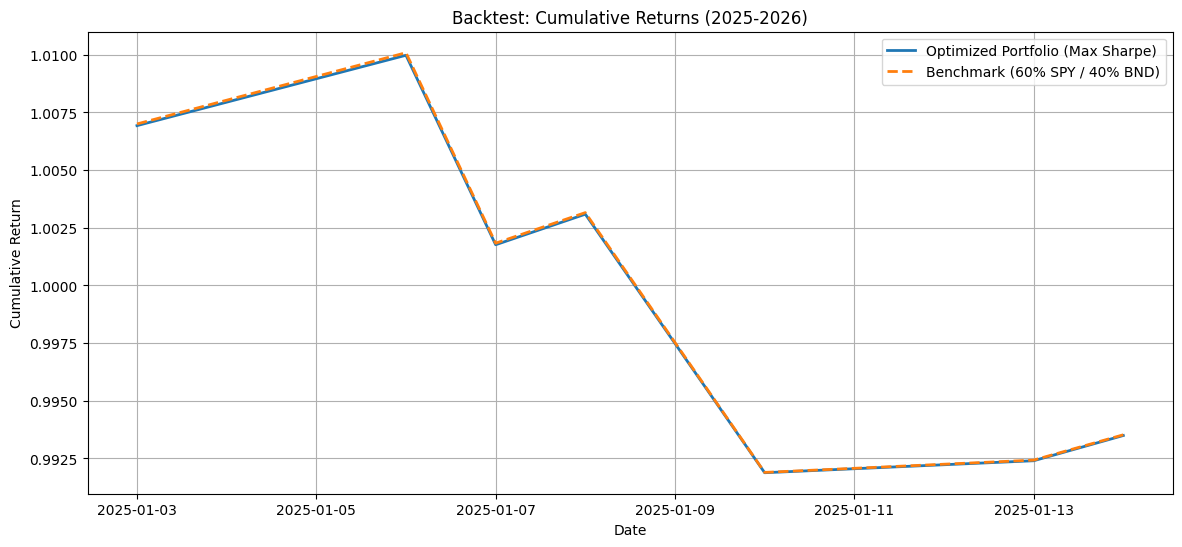

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(strategy_cum, label='Optimized Portfolio (Max Sharpe)', linewidth=2)
plt.plot(benchmark_cum, label='Benchmark (60% SPY / 40% BND)', linewidth=2, linestyle='--')
plt.title('Backtest: Cumulative Returns (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()